This is a simple CNN for the classification of bat species based on echolocation calls

In [11]:
!pip install tensorflow.config

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tensorflow.config (from versions: none)
ERROR: No matching distribution found for tensorflow.config


In [10]:
import librosa
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import sqlite3
import os

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

AttributeError: module 'tensorflow' has no attribute 'config'

In [2]:
# Connect to drive and load db
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
db_path = 'batcallsv14.db'

In [3]:
# DON'T!
# Load calls from db

# Set a fixed number of calls per species, or set to 0 to include all calls
num_calls = 0

# Select specific species for classification
targets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] # Großer Abendsegler - Nyctalus noctula, Zwergfledermaus - Pipistrellus pipistrellus

all_rows = []

# Make array from the binary data in the database
def _convert_array(text):
	out = io.BytesIO(text)
	out.seek(0)
	return np.load(out, allow_pickle=True)

# Make sqlite3 binary from the given array (probably for saving the array in the database)
def _adapt_array(arr):
	out = io.BytesIO()
	np.save(out, arr)
	out.seek(0)
	return sqlite3.Binary(out.read())

sqlite3.register_adapter(np.ndarray, _adapt_array)
sqlite3.register_converter("ARRAY", _convert_array)

with sqlite3.connect(db_path, detect_types=True) as con:
  cur = con.cursor()
  for target in targets:
    if num_calls > 0:
      rows = [x for x in cur.execute(f"SELECT * FROM batcalls WHERE target = {target} LIMIT {num_calls}")]
    else:
      rows = [x for x in cur.execute(f"SELECT * FROM batcalls WHERE target = {target}")]
    all_rows.extend(rows)

In [13]:
# Not in the flow! Copy&Paste
# view data gathered the provided way
from joblib import Parallel, delayed #Paralleize calculation

# Select specific species for classification
targets = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] # Großer Abendsegler - Nyctalus noctula, Zwergfledermaus - Pipistrellus pipistrellus

all_rows = []

# Make array from the binary data in the database
def _convert_array(text):
	out = io.BytesIO(text)
	out.seek(0)
	return np.load(out, allow_pickle=True)

# Make sqlite3 binary from the given array (probably for saving the array in the database)
def _adapt_array(arr):
	out = io.BytesIO()
	np.save(out, arr)
	out.seek(0)
	return sqlite3.Binary(out.read())

sqlite3.register_adapter(np.ndarray, _adapt_array)
sqlite3.register_converter("ARRAY", _convert_array)


def view_data(target):
    # Connect to the SQLite database
    conn = sqlite3.connect('batcallsv14.db')
    cursor = conn.cursor()
    # Retrieve the image data as a byte array
    query = f"SELECT arr FROM batcalls where target = {target}"
    df = pd.read_sql_query(query, conn)
    
    statistics = data.describe()
    name = f'statistics/Bat.describe_target{target}.csv'
    statistics.to_csv(name)
    return df

dataframes = Parallel(n_jobs=-3, prefer="threads")(delayed(view_data)(target) for target in targets)
df = pd.concat(dataframes)
statistics = df.describe()
statistics.to_csv('full_statistic.csv')

# Total NaN count across the DataFrame
total_nan_count = df.isna().sum().sum()
# NaN count per column
nan_count_per_column = df.isna().sum()
print("Total NaN count:", total_nan_count)
print("NaN count per column:\n", nan_count_per_column)



Total NaN count: 0

NaN count per column:
 arr       0
target    0
dtype: int64


In [17]:
# DON'T!!!
# Make spectrograms from db rows

def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band', output='ba')
  return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

def make_sets(data_rows):
  spec_list = []
  label_list = []
  for row in data_rows:
    target_class = targets.index(row[1])
    call = row[4].astype(np.float32, order='C') / 32768.0 # Why 32768.0?

    # Bandpass to filter low and high frequencies
    data_bp = butter_bandpass_filter(call, 1500, 12000, 44100, 5)

    # Normalize
    data_bp -= np.mean(data_bp)
    data_bp /= np.std(data_bp)

    # Calculate spectrogram with FFT
    stft = np.abs(librosa.stft(data_bp, n_fft=512, hop_length=32))
    stft = 10 * np.log10(stft)
    stft = np.nan_to_num(stft)

    # Scale between [0,1] and reduce shape if needed
    stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
    stft = np.reshape(stft, (257, 138, 1))
    stft = stft[:256, -128: , :]

    spec_list.append(stft)
    label_list.append(target_class)
  return spec_list, label_list

spectrograms, labels = make_sets(all_rows)

/tmp/ipykernel_10029/53683548.py:31: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


In [6]:
def test_train_split(spectrograms, labels, batchsize, train_split=0.7, val_split=0.2, test_split=0.1):

  dataset = tf.data.Dataset.from_tensor_slices((spectrograms, labels))
  dataset = dataset.shuffle(buffer_size=2, seed=42)

  train_size = int(train_split * len(spectrograms))
  val_size = int(val_split * len(spectrograms))

  train_dataset = dataset.take(train_size)
  val_dataset = dataset.skip(train_size).take(val_size)
  test_dataset = dataset.skip(train_size).skip(val_size)

  train_dataset = train_dataset.batch(batchsize)
  val_dataset = val_dataset.batch(batchsize)
  test_dataset = test_dataset.batch(batchsize)

  return train_dataset, val_dataset, test_dataset

In [7]:
# Simple CNN for binary classification

def generate_CNN():
  model = tf.keras.models.Sequential()
  # Note the input shape is the desired size of the image 200x200 with 3 bytes color
  # This is the first convolution
  model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256, 128, 1)))
  model.add(MaxPooling2D(2, 2))
  # The second convolution
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  # The third convolution
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  # The fourth convolution
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  # # The fifth convolution
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  # Flatten the results to feed into a DNN
  model.add(Flatten())
  # 512 neuron hidden layer
  model.add(Dense(512, activation='relu'))
  # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
  model.add(Dense(1, activation='sigmoid'))

  model.summary()
  keras.utils.plot_model(model, "simple_CNN.png", show_shapes=True)
  return model

In [8]:
# Generate and compile model

model = generate_CNN()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=RMSprop(learning_rate=0.001),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 63, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 61, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 14, 64)        0

2023-12-23 16:43:38.832933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7098 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


In [9]:
# Create datasets
train_dataset, validation_dataset, test_dataset = test_train_split(spectrograms, labels, train_split=0.7, val_split=0.2, test_split=0.1, batchsize=32)

In [10]:
# Train model

epochs = 150
history = model.fit(train_dataset,
      epochs=epochs,
      validation_data = validation_dataset
    )

Epoch 1/150


2023-12-23 16:44:26.490630: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-23 16:44:27.461184: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd8b20203b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-23 16:44:27.461208: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-12-23 16:44:27.475792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703346267.559835    4835 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 [==============================] - 4s 55ms/step - loss: 0.3657 - accuracy: 0.8381 - val_loss: 0.0648 - val_accuracy: 1.0000
Epoch 2/150
27/27 [==============================] - 0s 18ms/step - loss: 0.6025 - accuracy: 0.6476 - val_loss: 0.1808 - val_accuracy: 1.0000
Epoch 3/150
27/27 [==============================] - 0s 18ms/step - loss: 0.5372 - accuracy: 0.6857 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 4/150
27/27 [==============================] - 1s 19ms/step - loss: 0.6657 - accuracy: 0.6845 - val_loss: 0.1862 - val_accuracy: 1.0000
Epoch 5/150
27/27 [==============================] - 1s 20ms/step - loss: 0.5836 - accuracy: 0.6833 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 6/150
27/27 [==============================] - 1s 19ms/step - loss: 0.6875 - accuracy: 0.6476 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 7/150
27/27 [==============================] - 1s 19ms/step - loss: 0.6823 - accuracy: 0.6857 - val_loss: 0.1302 - val_accuracy: 1.0000
Epoch 8/150
27/27 

27/27 [==============================] - 1s 19ms/step - loss: 0.0403 - accuracy: 0.9869 - val_loss: 0.0037 - val_accuracy: 0.9958
Epoch 116/150
27/27 [==============================] - 0s 18ms/step - loss: 0.0430 - accuracy: 0.9857 - val_loss: 0.0038 - val_accuracy: 0.9958
Epoch 117/150
27/27 [==============================] - 1s 19ms/step - loss: 0.0462 - accuracy: 0.9845 - val_loss: 0.0052 - val_accuracy: 0.9958
Epoch 118/150
27/27 [==============================] - 1s 19ms/step - loss: 0.0393 - accuracy: 0.9893 - val_loss: 0.0043 - val_accuracy: 0.9958
Epoch 119/150
27/27 [==============================] - 0s 18ms/step - loss: 0.0374 - accuracy: 0.9881 - val_loss: 0.0050 - val_accuracy: 0.9958
Epoch 120/150
27/27 [==============================] - 1s 19ms/step - loss: 0.0350 - accuracy: 0.9893 - val_loss: 0.0039 - val_accuracy: 0.9958
Epoch 121/150
27/27 [==============================] - 1s 19ms/step - loss: 0.0308 - accuracy: 0.9917 - val_loss: 0.0044 - val_accuracy: 0.9958
Epoch 

Text(0.5, 1.0, 'Training and Validation Loss')

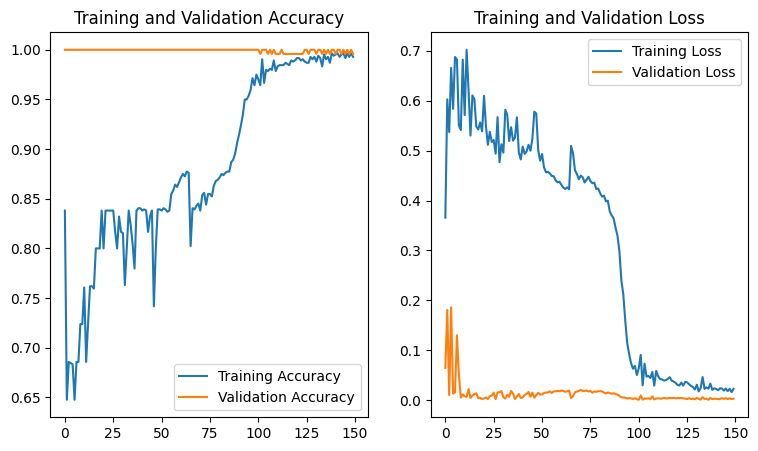

In [11]:
# Plot loss and accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [12]:
# Test prediction
test_loss, test_accuracy = model.evaluate(test_dataset)

4/4 [==============================] - 0s 89ms/step - loss: 0.0010 - accuracy: 1.0000
